### Import Packages

In [105]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.4 MB/s eta 0:00:00


In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
#!pip install shap
import shap

plt.rcParams["figure.figsize"] = (10, 6)

%matplotlib inline

Load data

In [19]:
df = pd.read_csv('CO2 Emissions_Canada.csv')

In [20]:
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [21]:
df.shape

(7385, 12)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

There is no missing values in the df, and there are 5 object variables


In [23]:
#rename columns
rename = {
    'Vehicle Class': 'vehicle_class',
    'Engine Size(L)': 'engine_size',
    'Fuel Type': 'fuel_type',
    'Fuel Consumption City (L/100 km)': 'fuel_consumption_city',
    'Fuel Consumption Hwy (L/100 km)': 'fuel_consumption_hwy',
    'Fuel Consumption Comb (L/100 km)': 'fuel_consumption_comb',
    'Fuel Consumption Comb (mpg)': 'mpgfuel_consumption_comb',
    'CO2 Emissions(g/km)': 'co2' }
df.rename(rename, axis='columns', inplace=True)

In [24]:
df.describe().T #we need to standardize the df

,count,mean,std,min,25%,50%,75%,max
engine_size,7385.0,3.160068,1.354170,0.9,2.0,3.0,3.7,8.4
Cylinders,7385.0,5.615030,1.828307,3.0,4.0,6.0,6.0,16.0
fuel_consumption_city,7385.0,12.556534,3.500274,4.2,10.1,12.1,14.6,30.6
fuel_consumption_hwy,7385.0,9.041706,2.224456,4.0,7.5,8.7,10.2,20.6
fuel_consumption_comb,7385.0,10.975071,2.892506,4.1,8.9,10.6,12.6,26.1
mpgfuel_consumption_comb,7385.0,27.481652,7.231879,11.0,22.0,27.0,32.0,69.0
co2,7385.0,250.584699,58.512679,96.0,208.0,246.0,288.0,522.0


<ipython-input-25-fe43fffaf13b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


<Axes: >

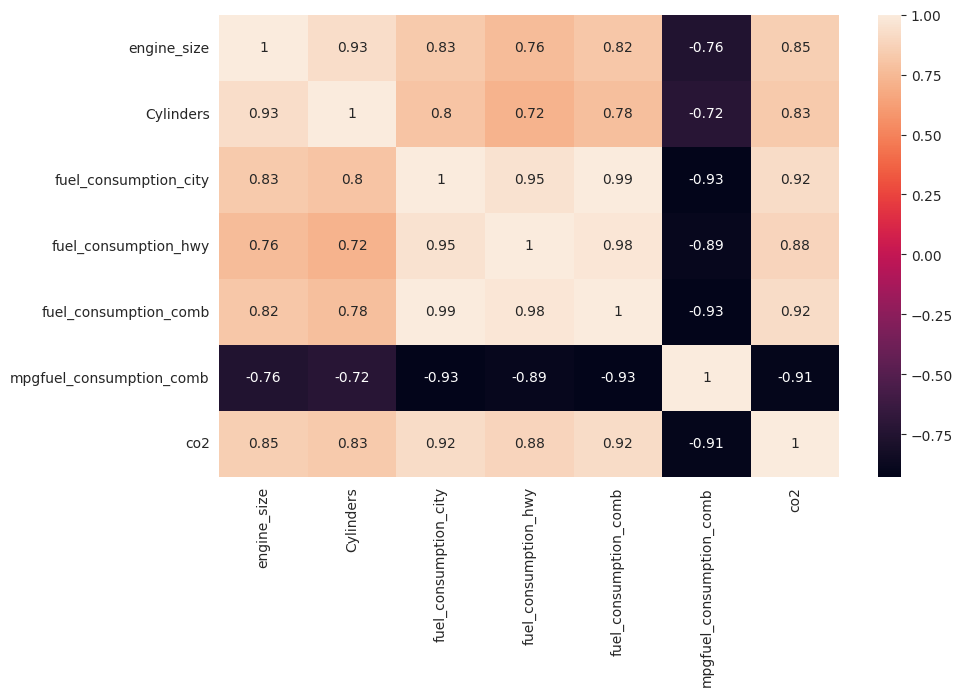

In [25]:
sns.heatmap(df.corr(), annot = True)

### Exploratory Data Analysis

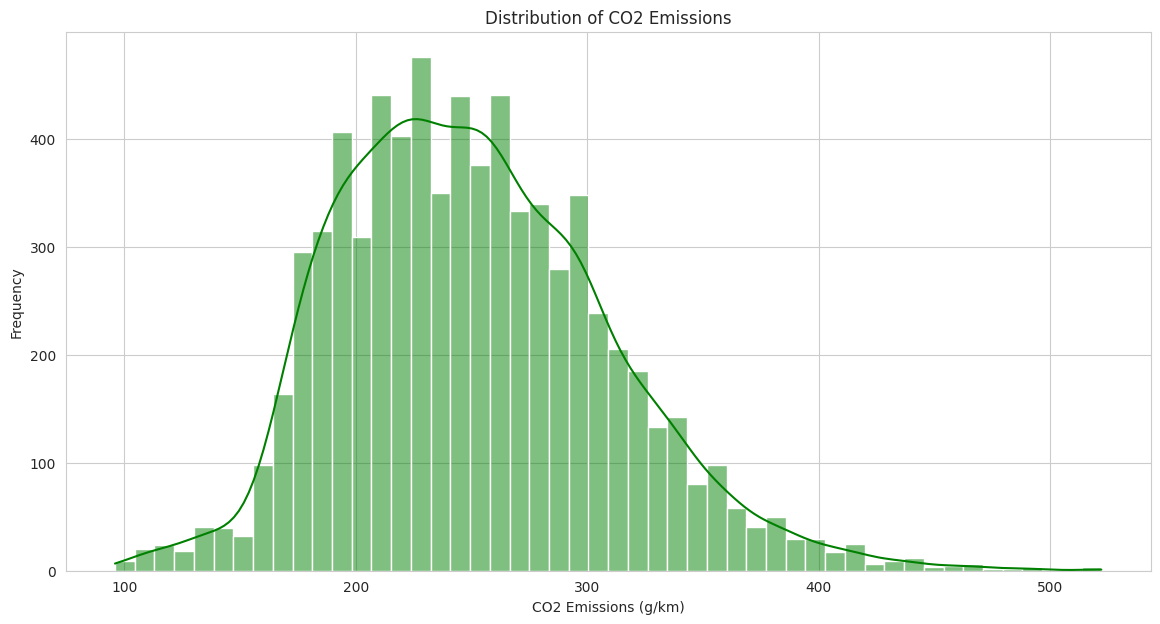

In [26]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Overview of CO2 Emissions across the dfset
plt.figure(figsize=(14, 7))
sns.histplot(df['co2'], kde=True, bins=50, color='green')
plt.title('Distribution of CO2 Emissions')
plt.xlabel('CO2 Emissions (g/km)')
plt.ylabel('Frequency')
plt.show()



The histogram shows a right-skewed distribution of CO2 emissions, indicating that a larger number of vehicles have lower emissions, with fewer vehicles having very high emissions.
There is a clear peak in the distribution, suggesting that there is a common range of CO2 emissions where most vehicles fall.
The long tail to the right suggests the presence of vehicles with significantly higher emissions, which could be outliers or specific types of vehicles with less efficient fuel consumption.

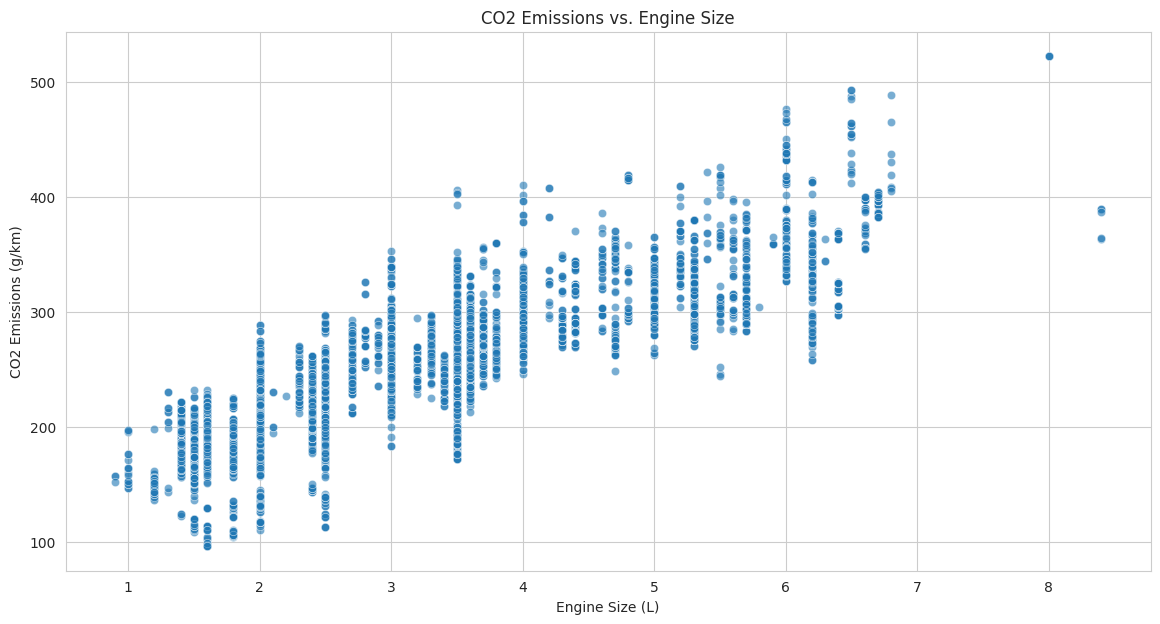

In [33]:
# Exploring the relationship between Engine Size and CO2 Emissions
plt.figure(figsize=(14, 7))
sns.scatterplot(x=df["engine_size"], y=df['co2'], alpha=0.6)
plt.title('CO2 Emissions vs. Engine Size')
plt.xlabel('Engine Size (L)')
plt.ylabel('CO2 Emissions (g/km)')
plt.show()


There is a positive correlation between engine size and CO2 emissions; as engine size increases, CO2 emissions tend to increase as well.
The scatter plot indicates a wide variation in emissions at each engine size level, suggesting that while engine size is an influential factor, it is not the sole determinant of emissions.
Some vehicles with large engines have emissions comparable to those with smaller engines, which may be attributed to factors such as engine technology, vehicle weight, and aerodynamics.

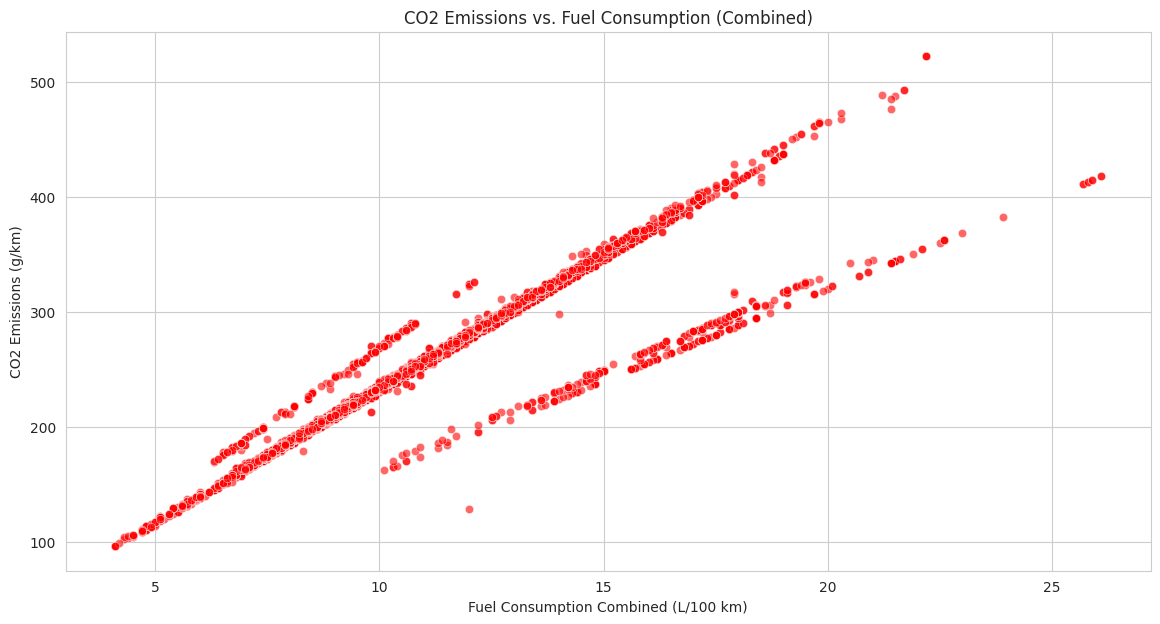

In [34]:

# Exploring the relationship between Fuel Consumption Comb (L/100 km) and CO2 Emissions
plt.figure(figsize=(14, 7))
sns.scatterplot(x=df['fuel_consumption_comb'], y=df['co2'], alpha=0.6, color='red')
plt.title('CO2 Emissions vs. Fuel Consumption (Combined)')
plt.xlabel('Fuel Consumption Combined (L/100 km)')
plt.ylabel('CO2 Emissions (g/km)')
plt.show()



The scatter plot shows a strong positive correlation between combined fuel consumption and CO2 emissions. This indicates that vehicles with higher fuel consumption tend to emit more CO2.
The tight clustering of points along the trend line suggests that fuel consumption is a strong predictor of CO2 emissions for these vehicles.

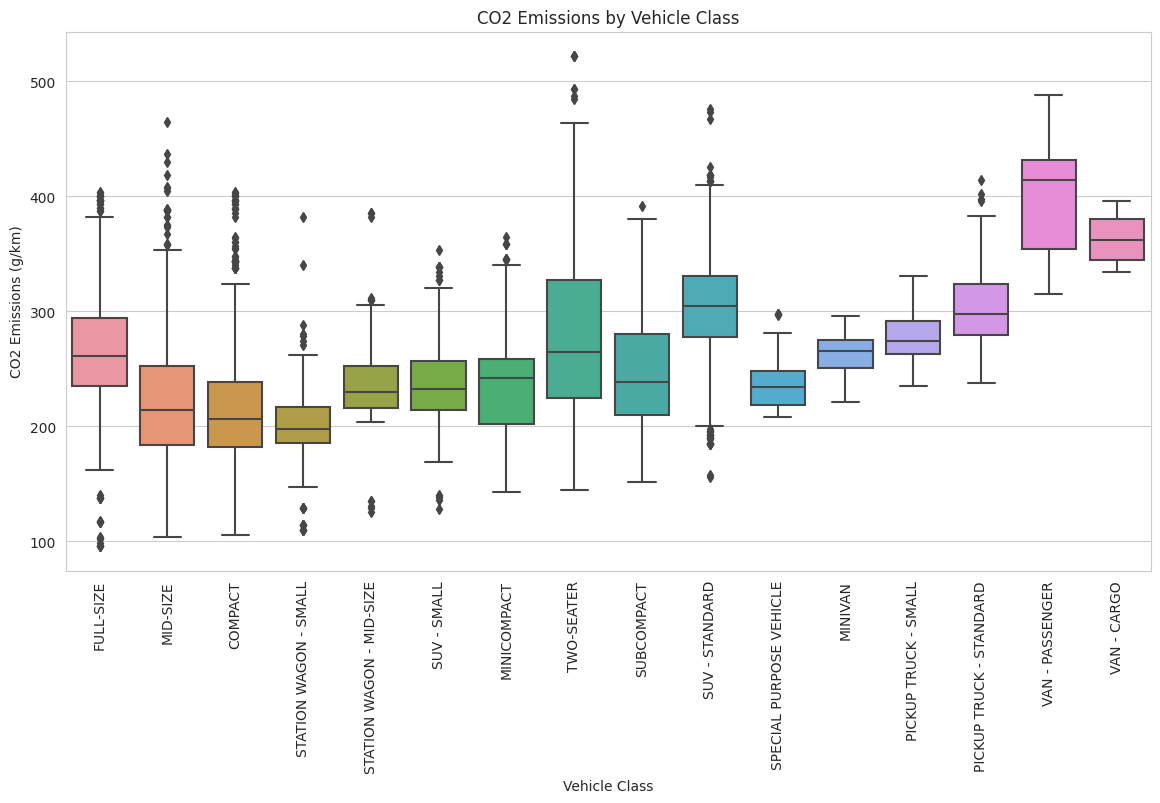

In [40]:

# Boxplot for CO2 Emissions by Vehicle Class
plt.figure(figsize=(14, 7))
sorted_df = df.sort_values('co2')
sns.boxplot(x=sorted_df['vehicle_class'], y=sorted_df['co2'])
plt.xticks(rotation=90)
plt.title('CO2 Emissions by Vehicle Class')
plt.xlabel('Vehicle Class')
plt.ylabel('CO2 Emissions (g/km)')
plt.show()



The boxplot by vehicle class reveals significant variation in emissions across different classes.
Some classes, like SUVs and larger vehicles, show higher median emissions and greater variability, suggesting that they are less fuel-efficient on average.
Compact and smaller vehicle classes exhibit lower median emissions and less variability, indicating more consistent fuel efficiency.

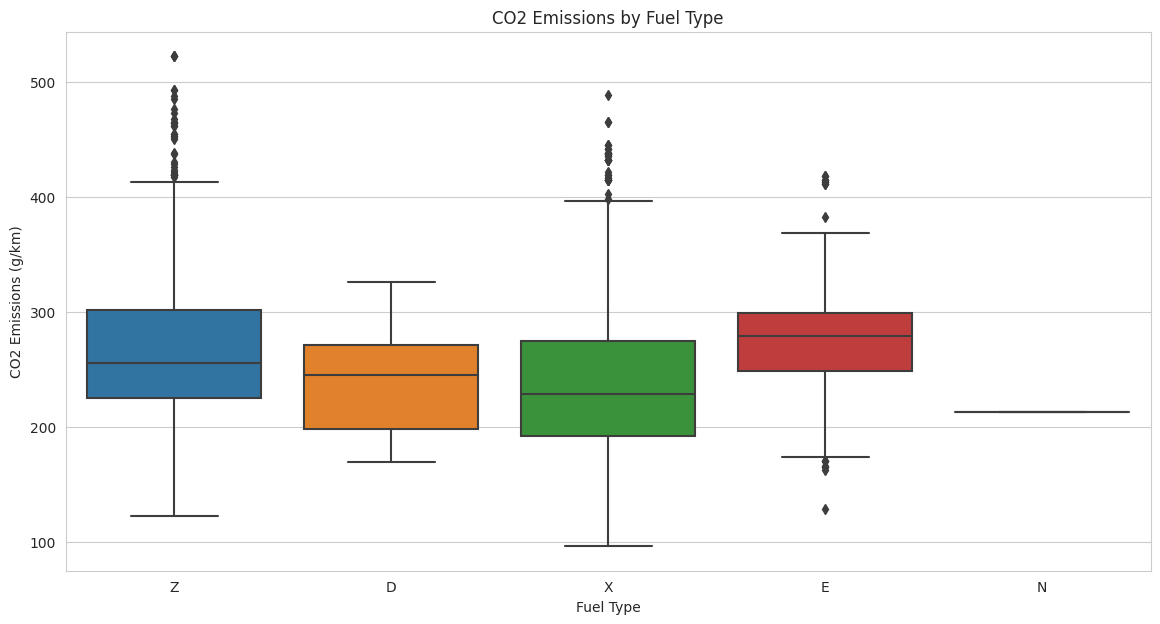

In [41]:
# Boxplot for CO2 Emissions by Fuel Type
plt.figure(figsize=(14, 7))
sns.boxplot(x=df['fuel_type'], y=df['co2'])
plt.title('CO2 Emissions by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('CO2 Emissions (g/km)')
plt.show()



In [43]:
df[df['fuel_type'] == 'N']

,Make,Model,vehicle_class,engine_size,Cylinders,Transmission,fuel_type,fuel_consumption_city,fuel_consumption_hwy,fuel_consumption_comb,mpgfuel_consumption_comb,co2
2439,CHEVROLET,IMPALA DUAL FUEL,MID-SIZE,3.6,6,AS6,N,15.2,9.5,12.7,22,213


In [44]:

df = df.drop(df[df['fuel_type'] == 'N'].index)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7384 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Make                      7384 non-null   object 
 1   Model                     7384 non-null   object 
 2   vehicle_class             7384 non-null   object 
 3   engine_size               7384 non-null   float64
 4   Cylinders                 7384 non-null   int64  
 5   Transmission              7384 non-null   object 
 6   fuel_type                 7384 non-null   object 
 7   fuel_consumption_city     7384 non-null   float64
 8   fuel_consumption_hwy      7384 non-null   float64
 9   fuel_consumption_comb     7384 non-null   float64
 10  mpgfuel_consumption_comb  7384 non-null   int64  
 11  co2                       7384 non-null   int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 749.9+ KB


The CO2 emissions vary by fuel type, with some fuels associated with higher emissions.
It is worth noting the spread and outliers within each fuel type category, as they suggest that fuel type alone does not determine emissions levels—other vehicle attributes also play a role.
Alternative fuel types might show a different emissions profile, indicating potential areas for reducing overall emissions through fuel choice.

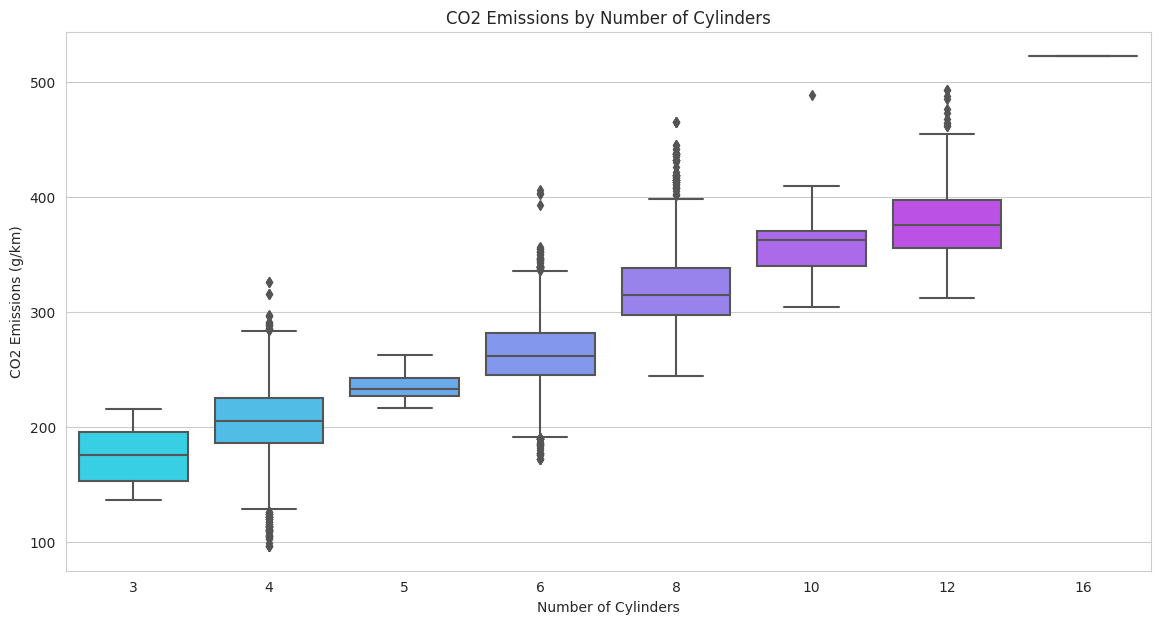

In [42]:

# Exploring the relationship between Cylinders and CO2 Emissions
plt.figure(figsize=(14, 7))
sns.boxplot(x=df['Cylinders'], y=df['co2'], palette="cool")
plt.title('CO2 Emissions by Number of Cylinders')
plt.xlabel('Number of Cylinders')
plt.ylabel('CO2 Emissions (g/km)')
plt.show()

There is a trend where vehicles with more cylinders tend to have higher CO2 emissions.
However, there is overlap in the interquartile ranges, which means that some vehicles with a higher number of cylinders have emissions comparable to those with fewer cylinders.
The presence of outliers, particularly in the categories with more cylinders, indicates that some vehicles are significantly less efficient than the majority.

### Preprocessing

In [45]:
# Calculating IQR to identify outliers in the 'co2' column
Q1 = df['co2'].quantile(0.25)
Q3 = df['co2'].quantile(0.75)
IQR = Q3 - Q1

# Defining outliers
outlier_condition = ((df['co2'] < (Q1 - 1.5 * IQR)) | (df['co2'] > (Q3 + 1.5 * IQR)))

# Counting outliers
outliers_count = df[outlier_condition].shape[0]

# Removing outliers
df_no_outliers = df[~outlier_condition]

In [47]:
df = df_no_outliers.copy()
df.shape

(7304, 12)

Deal with categorical variables

In [53]:
# One-hot encoding the nominal variables 'vehicle_class', 'fuel_type'
encoded_df = pd.get_dummies(df, columns=['vehicle_class', 'fuel_type'])

encoded_shape = encoded_df.shape
encoded_head = encoded_df.head()

encoded_shape

(7304, 30)

In [54]:
encoded_df.drop(['Make', 'Model','Transmission'], axis=1, inplace=True)


In [57]:
df = encoded_df.copy()

Standardization

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7304 entries, 0 to 7384
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   engine_size                             7304 non-null   float64
 1   Cylinders                               7304 non-null   int64  
 2   fuel_consumption_city                   7304 non-null   float64
 3   fuel_consumption_hwy                    7304 non-null   float64
 4   fuel_consumption_comb                   7304 non-null   float64
 5   mpgfuel_consumption_comb                7304 non-null   int64  
 6   co2                                     7304 non-null   int64  
 7   vehicle_class_COMPACT                   7304 non-null   uint8  
 8   vehicle_class_FULL-SIZE                 7304 non-null   uint8  
 9   vehicle_class_MID-SIZE                  7304 non-null   uint8  
 10  vehicle_class_MINICOMPACT               7304 non-null   uint

In [62]:

non_binary_cols = ['engine_size','Cylinders', 'fuel_consumption_city', 'fuel_consumption_hwy', 'fuel_consumption_comb', 'mpgfuel_consumption_comb']

# Perform standardization on the non-binary columns
scaler = StandardScaler()
df[non_binary_cols] = scaler.fit_transform(df[non_binary_cols])


### Model

Split data

In [98]:
X = df.drop('co2', axis=1)  # independent variables
y = df['co2']  # dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#### Linear Regression

In [67]:
lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

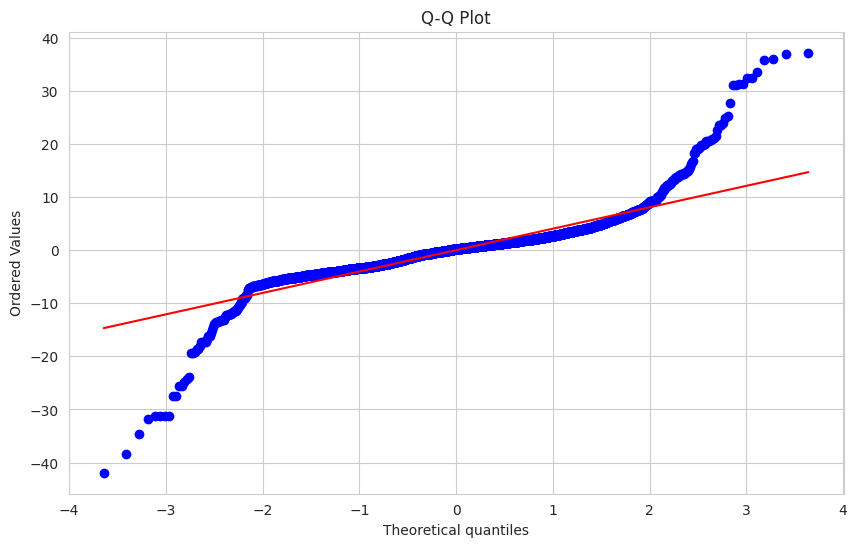

Durbin-Watson statistic: 1.9988118283037426


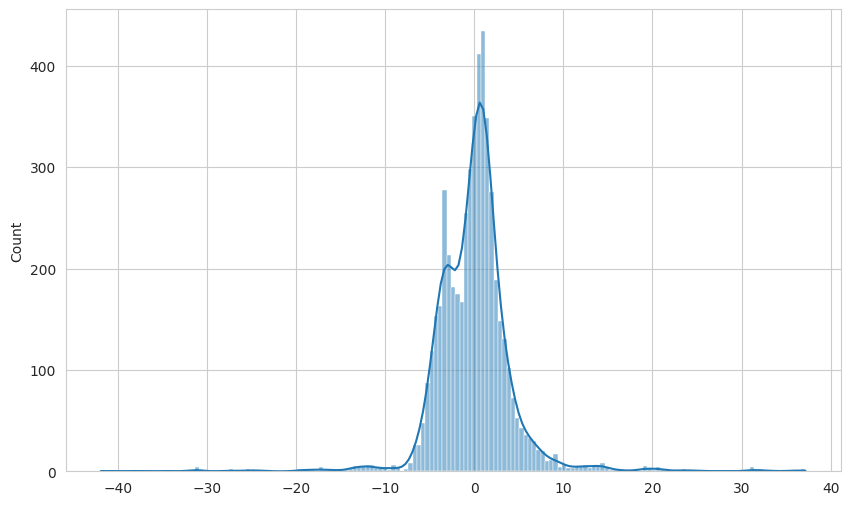

In [73]:
# check assumptions
X_train_sm = sm.add_constant(X_train)  # adding a constant
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Residuals
residuals = model_sm.resid
# Check for Normality of Residuals
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# Histogram of residuals
sns.histplot(residuals, kde=True)

# For Independence of Residuals
# Durbin-Watson test
print('Durbin-Watson statistic:', sm.stats.durbin_watson(residuals))


In [69]:
#model evaluation
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 20.80708818069991
R-squared: 0.9932627566914142


After thorough attempts to normalize the residuals through transformations of the dependent variable, our analysis indicates that the data still does not adhere to the fundamental assumptions required for linear regression. This deviation suggests that linear regression may not be the most suitable model for our dataset. Consequently, we have decided to explore alternative modeling approaches that are more robust to violations of these assumptions.

#### Random Forest

In [81]:
# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Cross-validation
scores = cross_val_score(rf, X_train, y_train, cv=5)
print(f'Cross-validation scores: {scores}')
print(f'Mean cross-validation score: {np.mean(scores)}')

# Model evaluation
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



Cross-validation scores: [0.9977227  0.99633392 0.99681733 0.99684932 0.99749116]
Mean cross-validation score: 0.9970428869553369
Mean Squared Error: 6.316131696081828
R-squared: 0.9979548644367718


In [84]:
feature_imp = pd.DataFrame({'Importance': rf.feature_importances_}, index=X.columns)
feature_imp.sort_values('Importance', ascending=False, inplace=True)
feature_imp.head(10)


,Importance
fuel_consumption_comb,0.820733
mpgfuel_consumption_comb,0.095378
fuel_type_E,0.036790
engine_size,0.027506
fuel_consumption_city,0.008018
fuel_type_D,0.006372
Cylinders,0.003596
fuel_consumption_hwy,0.000973
vehicle_class_SUV - SMALL,0.000079
vehicle_class_COMPACT,0.000075


#### XGBoost

In [100]:

# Define the model
xgb = xgb.XGBRegressor()

# Define the hyperparameter grid
hyperparameters = {
    'n_estimators': [100,300],
    'learning_rate': [ 0.05, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.6, 0.8],
    'reg_alpha': [0.1, 0.2],
    'reg_lambda': [0.1, 0.2],
    'gamma': [ 0.1, 0.5]
}

# Create the grid search object
grid_search = GridSearchCV(xgb, hyperparameters, cv=5)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

# Print the best score
print(grid_search.best_score_)


{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 0.2, 'reg_lambda': 0.2, 'subsample': 0.5}
0.997143802253363


In [104]:

xgb_best = XGBRegressor(**grid_search.best_params_)
xgb_best.fit(X_train, y_train)

y_pred = xgb_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 6.858244703098176
R-squared: 0.9977793306380346


[07:03:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[07:03:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


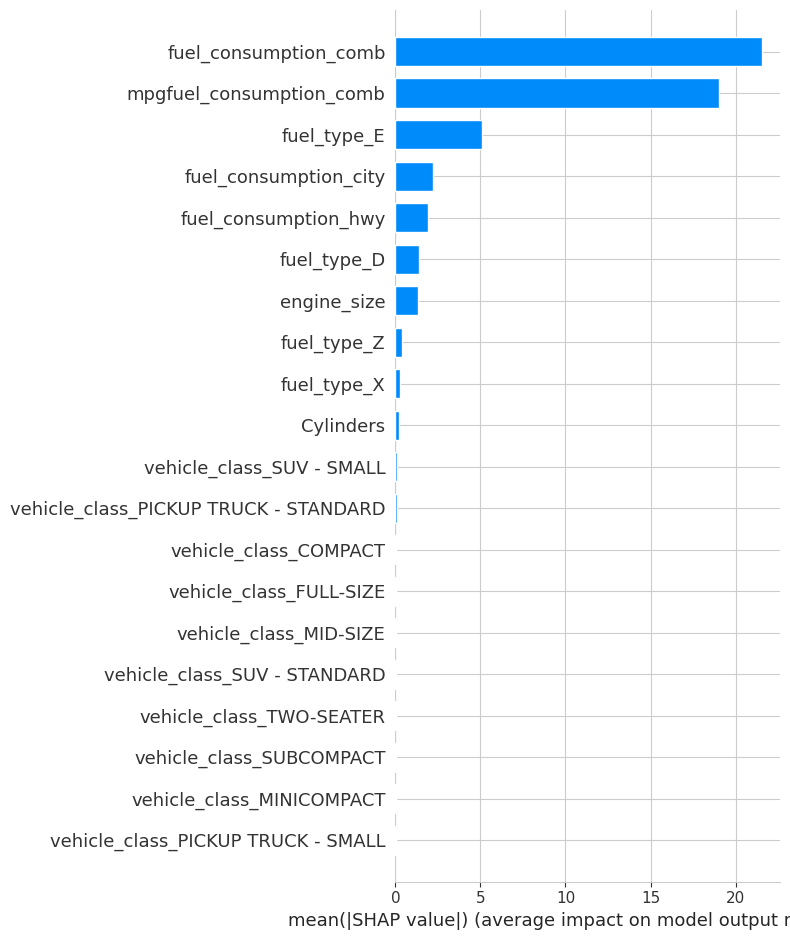

In [107]:
explainer = shap.Explainer(xgb_best)
# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


The SHAP summary plot provides a visual representation of the feature importance as determined by our XGBoost model. Each feature's impact on the model output is quantified by the SHAP value, where a higher absolute SHAP value indicates a greater impact on the model's predictions. \

**Fuel Consumption Combined (fuel_consumption_comb):** This feature has the highest average impact on the model's output, indicating that the combined fuel consumption is the most influential factor in predicting CO2 emissions. Policies aimed at reducing fuel consumption or improving fuel efficiency are likely to have the greatest impact on reducing emissions.

**MPG Fuel Consumption Combined (mpgfuel_consumption_comb)**: Interestingly, this feature, which appears to be another representation of fuel efficiency, also shows a significant impact on the model's output. This suggests that both metric and imperial measurements of fuel efficiency are important predictors,reflecting different segments of the dataset or varied regulatory standards.

**Fuel Type E (fuel_type_E):** The third most impactful feature. As'E' represents a cleaner fuel type such as ethanol or electric, this importance underscores the potential CO2 emission reductions achievable by switching to more environmentally friendly fuels.

**City and Highway Fuel Consumption (fuel_consumption_city and fuel_consumption_hwy)**: While these features have a smaller impact than the combined fuel consumption, they still influence CO2 emissions predictions. It indicates that the model differentiates between urban and highway driving patterns when assessing emissions.

**Fuel Type D (fuel_type_D):** As 'D' stands for diesel, its position on the plot suggests that diesel fuel's impact on emissions is significant but less so than the cleaner 'E' type. This aligns with diesel fuel's characteristics and its environmental considerations.

**Engine Size (engine_size) and Cylinders:** These features have a moderate impact on the model output, confirming the mechanical attributes of the vehicle play a role in determining emissions, although they are less influential than fuel-related features.

**Vehicle Classes:** The impact of vehicle class on CO2 emissions is relatively lower. However, specific classes such as 'SUV - SMALL' and 'PICKUP TRUCK - STANDARD' have a non-negligible effect. This may point to the influence of vehicle size and design on emissions, although they are not the primary drivers.

We could read from Shap summary to see where are the efforts to improve fuel efficiency, particularly in urban driving conditions, and a transition towards cleaner fuel types could significantly reduce vehicle CO2 emissions. It also suggests that while vehicle design factors like engine size and class play a role, they are secondary to how the vehicle is used and fueled. This information could guide manufacturers and policymakers in developing and promoting greener vehicles.